# Pendulum with Structured LNN and Control
- We know the data is angle and use it as advantage

## TODO:

- Plot Mass Matrix
- Plot Potential
- Understand the control

In [1]:
import numpy as np
import torch

import sys
sys.path.append("../../")

## Train Model

In [2]:
# hparams
num_sample = 50
batch_size = num_sample
portion = 0.5

learning_rate = 3e-4
min_delta = 0
patience = 20

time_horizon = 10
solver = 'rk4'

model_name = 'test.pt'
# Check Model params in Model section

### Set Seed Here

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Create the data set
- init_condition: list of tuple

 [(x0, p0, t0, t1, steps)]

In [4]:
from gym_env import PendulumCustomEnv
from data import Gym_DataModule_rng

In [5]:
env = PendulumCustomEnv(full_phase=True)
low = np.array([-2])
high = -low

# env, time step, traj, control
dataModule = Gym_DataModule_rng(env,
                                num_sample,
                                low=low,
                                high=high,
                                portion=portion,
                                time_horizon=time_horizon,
                                batch_size=batch_size)

dataModule.setup()

/Users/fei/Documents/UCL/Thesis/Code/MBRL_HNN/experiment/Pendulum/../../data/generate_traj.py:243: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  extra.append(np.array([info['th'], info['dth'], info['ddth']]))


In [6]:
print(dataModule.dataset.tensors[0].shape)  # (bs, time, [cos q, sin, q, dq])
print(dataModule.dataset.tensors[1].shape)  # (bs, time, [control])
print(dataModule.dataset.tensors[2].shape)  # (bs, time, [time])
print(dataModule.dataset.tensors[3].shape)  # (bs, time, [th, dth, ddth])

torch.Size([50, 10, 3])
torch.Size([50, 10, 1])
torch.Size([50, 10, 1])
torch.Size([50, 10, 3])


### Define Model

In [7]:
from torchdyn.models import NeuralODE

from module import LNN
from nn import MLP, PSD, MatrixNet

In [8]:
massMatrixNet = PSD([2, 64, 64, 1], activation='sigmoid')
potentialNet = MLP([2, 64, 64, 1], activation='sigmoid')
controlNet = MatrixNet([2, 64, 64, 1], control_dim=1, activation='sigmoid')

lagFunc = LNN(num_angle=1, 
              massMatrixNet=massMatrixNet,
              potentialNet=potentialNet,
              controlNet=controlNet)

lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver=solver).to(device)

### Pretrain with time horizon = 2

In [9]:
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

In [10]:
class Pre_learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss
        self.time_horizon = 2

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, u, t, _ = batch
        t_span = t[0, :self.time_horizon, 0]
        q_dq_u = torch.cat([x[:, :self.time_horizon, :], u[:, :self.time_horizon, :]], dim=2)  # Pick (q, dq, u)

        est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [11]:
pre_Learn = Pre_learner(lagODE)
pre_trainer = pl.Trainer(max_epochs=10)
pre_trainer.fit(pre_Learn, dataModule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f'you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop')

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init 

Training: 0it [00:00, ?it/s]

### Define Pytorch lightning trainer

In [12]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        x, u, t, _ = batch
        t_span = t[0, :, 0]
        q_dq_u = torch.cat([x[:, :, :], u[:, :, :]], dim=2)
        
        est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.logger.experiment.add_scalars("loss", {"train": loss}, self.current_epoch)
        return loss

    def validation_step(self, batch, batch_idx):
        x, u, t, _ = batch
        t_span = t[0, :, 0]
        q_dq_u = torch.cat([x[:, :, :], u[:, :, :]], dim=2)
        
        est = self.model.trajectory(q_dq_u[:, 0, :], t_span)

        loss = self.loss_func(q_dq_u, est.transpose(0, 1))
        
        self.log('val_loss', loss)
        self.logger.experiment.add_scalars("loss", {"val": loss}, self.current_epoch)
        return loss
    

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

In [13]:
learn = Learner(lagODE)

early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=min_delta, patience=patience)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Train

In [14]:
trainer.fit(learn, dataModule)


  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 13.3 K
------------------------------------
13.3 K    Trainable params
0         Non-trainable params
13.3 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.408
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0. New best score: 0.400


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0. New best score: 0.394


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0. New best score: 0.388


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0. New best score: 0.385


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.383


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 0.382


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.382


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.380


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0. New best score: 0.375


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 0.369


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0. New best score: 0.363


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 0.356


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0. New best score: 0.351


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0. New best score: 0.347


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0. New best score: 0.343


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0. New best score: 0.339


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0. New best score: 0.334


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0. New best score: 0.325


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0. New best score: 0.314


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0. New best score: 0.301


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0. New best score: 0.289


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0. New best score: 0.278


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0. New best score: 0.267


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0. New best score: 0.250


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0. New best score: 0.231


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0. New best score: 0.214


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0. New best score: 0.196


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0. New best score: 0.176


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0. New best score: 0.156


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0. New best score: 0.136


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.019 >= min_delta = 0. New best score: 0.117


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0. New best score: 0.100


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.017 >= min_delta = 0. New best score: 0.082


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0. New best score: 0.066


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0. New best score: 0.053


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0. New best score: 0.041


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0. New best score: 0.030


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0. New best score: 0.022


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0. New best score: 0.009


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.003


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.001. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 21 records. Best score: 0.001. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 22 records. Best score: 0.001. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 23 records. Best score: 0.001. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 24 records. Best score: 0.001. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 25 records. Best score: 0.001. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 26 records. Best score: 0.001. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 27 records. Best score: 0.001. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 20 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 21 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 22 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 23 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 24 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 25 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 26 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 27 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 28 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 29 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 30 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 31 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 32 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 33 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 34 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 35 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 36 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 37 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 38 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 39 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 40 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 41 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 42 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 43 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 44 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 45 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 46 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 47 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 48 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 49 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 50 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 51 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 52 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 53 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 54 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 55 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 56 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 57 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 58 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 59 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 60 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 61 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 62 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 63 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 64 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 65 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 66 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 67 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 68 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 69 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 70 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 71 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 72 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 73 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 74 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 75 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 76 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 77 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 78 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 79 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 80 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 81 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 82 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 83 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 84 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 85 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 86 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 87 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 88 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 89 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 90 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 91 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 92 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 93 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 94 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 95 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 96 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 97 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 98 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 99 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 100 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 101 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 102 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 103 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 104 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 105 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 106 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 107 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 108 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 109 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 110 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 111 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 112 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 113 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 114 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 115 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 116 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 117 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 118 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 119 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 120 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 121 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 122 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 123 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 124 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 125 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 126 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 127 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 128 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 129 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 130 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 131 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 132 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 133 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 134 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 135 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 136 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 137 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 138 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 139 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 140 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 141 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 142 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 143 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 144 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 145 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 146 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 147 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 148 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 149 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 150 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 151 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 152 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 153 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 154 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 155 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 156 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 157 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 158 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 159 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 160 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 161 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 162 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 163 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 164 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 165 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 166 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 167 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 168 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 169 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 170 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 171 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 172 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 173 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 174 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 175 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 176 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 177 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 178 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 179 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 180 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 181 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 182 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 183 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 184 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 185 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 186 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 187 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 188 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 189 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 190 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 191 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 192 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 193 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 194 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 195 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 196 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 197 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 198 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 199 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 200 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 201 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 202 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 203 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 204 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 205 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 206 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 207 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 208 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 209 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 210 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 211 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 212 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 213 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 214 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 215 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 216 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 217 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 218 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 219 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 220 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 221 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 222 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 223 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 224 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 225 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 226 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 227 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 228 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 229 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 230 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 231 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 232 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 233 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 234 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 235 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 236 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 237 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 238 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 239 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 240 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 241 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 242 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 243 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 244 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 245 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 246 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 247 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 248 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 249 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 250 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 251 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 252 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 253 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 254 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 255 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 256 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 257 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 258 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 259 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 260 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 261 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 262 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 263 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 264 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 265 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 266 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 267 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 268 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 269 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 270 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 271 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 272 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 273 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 274 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 275 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 276 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 277 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 278 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 279 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 280 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 281 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 282 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 283 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 284 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 285 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 286 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 287 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 288 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 289 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 290 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 291 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 292 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 293 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 294 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 295 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 296 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 297 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 298 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 299 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 300 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 301 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 302 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 303 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 304 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 305 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 306 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 307 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 308 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 309 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 310 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 311 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 312 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 313 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 314 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 315 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 316 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 317 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 318 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 319 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 320 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 321 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 322 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 323 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 324 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 325 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 326 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 327 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 328 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 329 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 330 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 331 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 332 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 333 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 334 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 335 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 336 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 337 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 338 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 339 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 340 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 341 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 342 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 343 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 344 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 345 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 346 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 347 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 348 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 349 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 350 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 351 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 352 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 353 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 354 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 355 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 356 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 357 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 358 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 359 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 360 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 361 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 362 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 363 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 364 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 365 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 366 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 367 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 368 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 369 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 370 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 371 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 372 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 373 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 374 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 375 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 376 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 377 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 378 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 379 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 380 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 381 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 382 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 383 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 384 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 385 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 386 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 387 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 388 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 389 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 390 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 391 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 392 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 393 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 394 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 395 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 396 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 397 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 398 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 399 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 400 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 401 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 402 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 403 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 404 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 405 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 406 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 407 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 408 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 409 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 410 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 411 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 412 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 413 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 414 records. Best score: 0.000. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 415 records. Best score: 0.000. Signaling Trainer to stop.


### Save Model
- Pytorch Lightning model check point is buggy
- Use Pytorch save and load method instead

In [15]:
torch.save(lagODE, 'models/{}'.format(model_name))

## Model Analysis

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [17]:
test_model = torch.load('models/{}'.format(model_name))
test_model.eval()

test_model = test_model

### Generate trajectory with Gym Env

In [18]:
# define testing time stamp
dt = 0.05
full = 1000
t_span = torch.linspace(dt, dt*full, full)

In [19]:
# Generate Trajectory
env.seed(0)
np.random.seed(0)

env = PendulumCustomEnv()
obs = []
infos = []

# control = 2
# controls = np.random.randint(-2, 2 + 1, full+1)
split = 20
controls = np.random.randint(-2, 2 + 1, int(full / split))
controls = np.repeat(controls, split)
# controls = np.zeros_like(controls)

# obs0, _ = env.reset(np.array([3., 1.]))
obs0, _ = env.reset(np.array([np.pi / 4, 0.]))

prev_obs = obs0
for i in range(full):
    obs.append(prev_obs)
    
    next_obs, reward, done, info = env.step(controls[i])
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    prev_obs = next_obs

obs = torch.tensor(obs)
infos = torch.tensor(infos)
controls = torch.Tensor(controls).view(-1, 1)

### Generate Prediction

In [20]:
from utils import traj_pred

# Generate prediction
q_dq_u = torch.cat([obs, controls], dim=1)
est_grad = test_model.defunc(0, q_dq_u.float())
est = traj_pred(0.05, test_model, obs0, controls)

In [21]:
from scipy.integrate import solve_ivp

def dummy(t, y):
    idx = int(torch.tensor(t) / dt)
    dx1 = np.multiply(-y[1], y[2])
    dx2 = np.multiply(y[0], y[2])
    ddq = -10 * y[0] + controls[idx-1] / 2.
    return [dx1, dx2, ddq]

sol = solve_ivp(dummy, [dt, dt*full], obs0, method='Radau', t_eval=t_span.detach().numpy())

In [22]:
print(sol.y.shape)
print(obs0)
# sol.t

(3, 1000)
[ 0.70710678 -0.70710678  0.        ]


### Check gradient

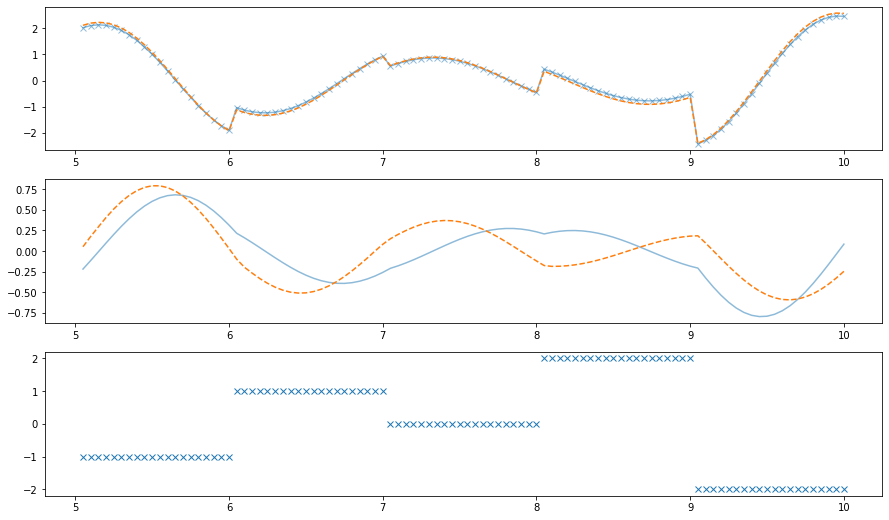

In [30]:
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

start = 100
end = 200

# Check ddq_est
ax1.plot(t_span.detach().numpy()[start:end], infos[start:end, 2],'x-', alpha=0.5)  # Ground truth
ax1.plot(t_span.detach().numpy()[start:end], est_grad[start:end, 2].detach().numpy(), '--')  # LNN

# check dq_est
ax2.plot(t_span.detach().numpy()[start:end], infos[start:end, 1],'-', alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est.y[2, start:end], '--')  # LNN
# ax2.plot(sol.t[start:end], sol.y[2, start:end])

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start:end],'x')
# None

### Check trajectory

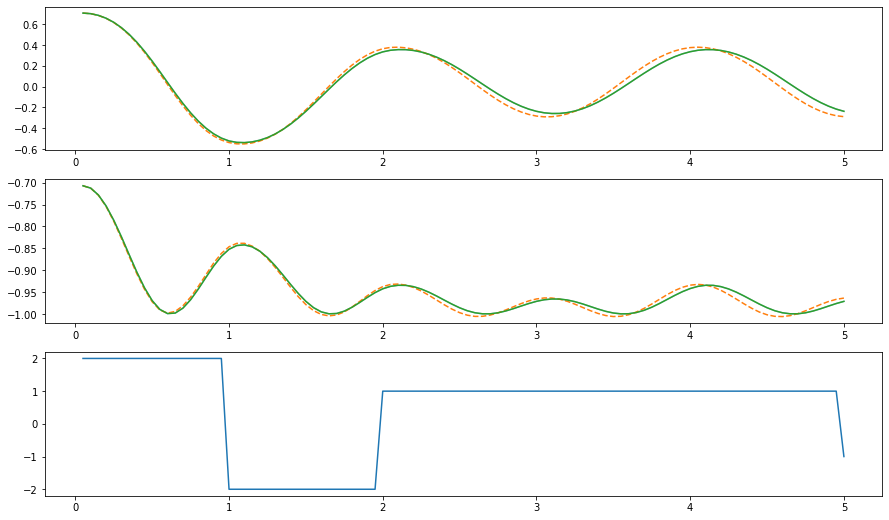

In [31]:
# Check trajectory
start = 0
end = 100

fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Plot cos q = x
ax1.plot(t_span.detach().numpy()[start:end], obs[start:end, 0].detach().numpy(), alpha=0.5)
ax1.plot(t_span.detach().numpy()[start:end], est.y[0, start:end], '--')
ax1.plot(sol.t[start:end], sol.y[0, start:end])

# Plot sin q = y
ax2.plot(t_span.detach().numpy()[start:end], obs[start:end, 1].detach().numpy(), alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est.y[1, start:end], '--')
ax2.plot(sol.t[start:end], sol.y[1, start:end])


# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start+1:end+1])
# None
None

### Plot Phase Space Trajectory

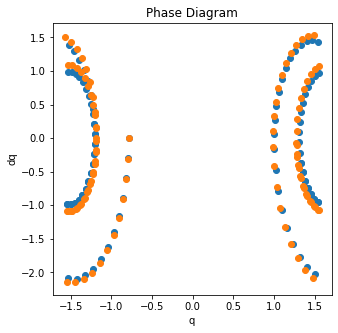

In [25]:
length = 100
# Plot Phase Space traj
th = torch.atan(obs[:length, 1] / obs[:length, 0])
thdot = obs[:length, 2]

est_th = torch.atan(torch.tensor(est.y[1, :length] / est.y[0, :length]))
est_thdot = est.y[2, :length]

fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(th, thdot)
plt.scatter(est_th, est_thdot)

ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Phase Diagram")
None

### Plot Mass Matrix

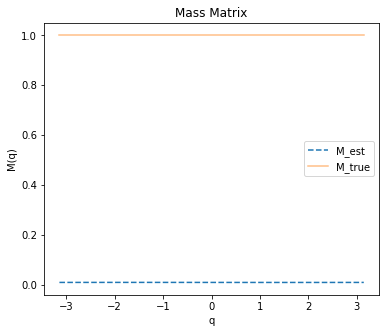

In [26]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

M_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    M_est[i] = test_model.defunc.m.massMatrixNet(q.view(1, -1)).detach().cpu()[0, 0, 0]

    
M_true = torch.ones(M_est.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), M_est, '--', label='M_est')
ax.plot(x.detach().numpy(), M_true, label='M_true', alpha=0.5)

ax.legend()
# ax.set_ylim([0, 1.1])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

### Plot Potential

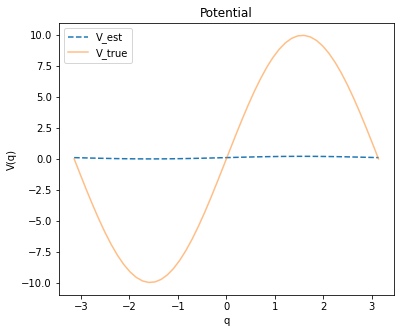

In [27]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

V_true = 1. * 10 * torch.sin(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    V_est[i] = test_model.defunc.m.potentialNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='V_est')
ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Potential")
None

### Plot Control

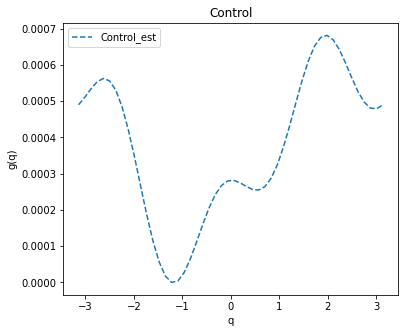

In [28]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
x1, x2 = torch.meshgrid(x, x)  # (cos q, sin q)

Control = 1. * 10 * torch.ones_like(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.stack([torch.cos(x[i]), torch.sin(x[i])])
    V_est[i] = test_model.defunc.m.controlNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='Control_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("g(q)")
ax.set_title("Control")
None

## Conclusion